# Clipping a GeoTIFF Image by a Shapefile

This notebook is an optional extension to the first step in the workflow which demonstrates how to 
clip an input GeoTIFF to any geometry you choose. In this case, I downloaded the US counties shapefile 
from the US Census Bureau. To accomplish this, we first read in the GeoTIFF image via Rasterio and the 
shapefile through geopandas. These two libraries are used a few times throughout the project, and I 
believe the development time tradeoff between using them and vanilla GDAL is well worth it, given the
fact they are both widely supported open source libraries. After reading in the shapefile's geometry, we 
mask the input GeoTIFF to the shapely poylgons. We then copy over the pertinent metadata to the output 
image and write the newly clipped data to the file. 


The only inputs here are: 
* In path to your shapefile
* In path to your freshly merged GeoTIFF, the output of the previous script
* Out path name to your clipped GeoTIFF
* In county GEOID to filter the large dataframe by


In [1]:
import geopandas as gpd
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
%matplotlib inline

Inputs of the county shapefile, geotiff path, and geoid

In [2]:
in_shp = r"C:\Users\moult\Documents\geospatial\data\shapefiles\tl_2019_us_county.shp"
in_tif = r"C:\Users\moult\Documents\geospatial\data\austin_merged_landsat\Austin_Landsat_2015.tif"
# in_tif = r"C:\Users\moult\Documents\geospatial\data\austin_merged_landsat\Austin_Landsat_2020.tif"

out_tif_path = r"..\..\data\austin_clipped_landsat\Austin_Landsat_Clip_2015.tif"
# out_tif_path = r"..\..\data\austin_clipped_landsat\Austin_Landsat_Clip_2020.tif"

#For this case, I input a known GEOID. You can search through the data yourself to find the appropriate county code
in_county_geoid = '48453'
counties_gdf = gpd.read_file(in_shp)
counties_gdf = counties_gdf[counties_gdf['GEOID'] == in_county_geoid]

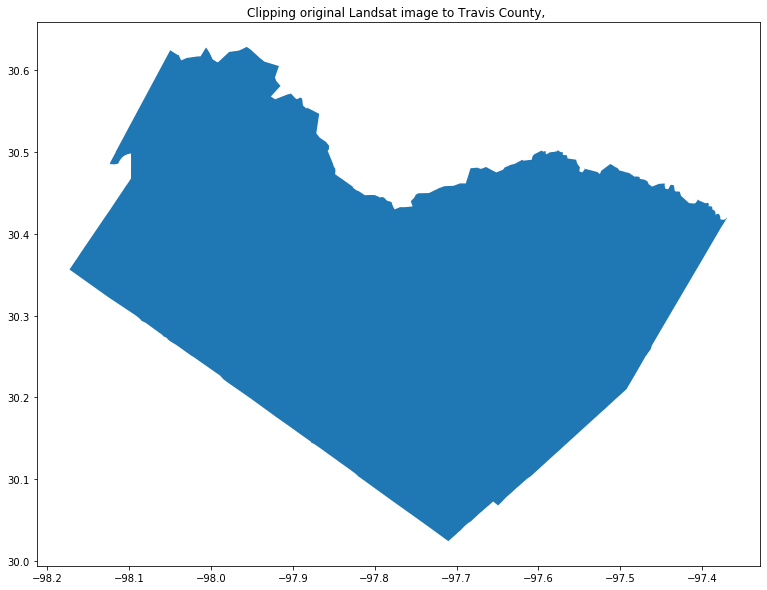

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
counties_gdf.plot(ax=ax)
ax.set_title('Clipping original Landsat image to {}, '.format(counties_gdf['NAMELSAD'].values[0]));

This cell opens up the original geotiff, reprojects the dataframe to the appropriate 
UTM zone, and performs the mask in just a couple lines:

In [4]:
with rasterio.open(in_tif) as src:
    prj = src.crs.to_wkt()
    counties_gdf_reproj = counties_gdf.to_crs(prj)
    shapes = [counties_gdf_reproj['geometry'].values[0]]
    
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

This final cell updates the output geotransformation with new dimensions
and then saves the clipped raster

In [5]:
out_meta.update({"driver":"GTiff",
                "height": out_image.shape[1],"width":out_image.shape[2],
                "transform": out_transform})

with rasterio.open(out_tif_path, "w", **out_meta) as dest:
    dest.write(out_image)